# Performing the Higgs -> WW-> 2 leptons search 





# Installation of packages not available by default on colab


In [ ]:
import sys
# update the pip package installer
#%pip install --upgrade --user pip
# install required packages
#%pip install --upgrade --user uproot awkward vector numpy matplotlib

!pip install uproot
!pip install vector
!pip install awkward
!pip install hist

## Import packages used in the analysis

We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us store data as awkward arrays, a format that generalizes numpy to nested data with possibly variable length lists
* vector: to allow vectorized 4-momentum calculations
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [1]:
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt
import pandas as pd


## Data fraction, file path

General definitions of fraction of data used, where to access the input files

In [2]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D
fraction = 625000 # reduce this is if you want the code to run quicker

<a id='fraction'></a>

In [3]:
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/" # web address

Units, as stored in the data files.<br /> 
The quantities in the ATLAS ntuple are unfortunately stored in MeV.<br />
Since the natural unit for LHC analysis is GeV, we define conversion factors

In [4]:
MeV = 0.001
GeV = 1.0
mz = 91.12

Define different classes of ntuples to access as a dictionary called "samples".<br />
One has four types of ntuples:<br />
<ul>
<li>Data: the real data collected by ATLAS at the LHC
<li>Reducible backgrounds: 
<li>Irreducible backgrounds
<li>Signal
</ul>
The names in the list must correspond to the names of a sample defined in infofile.py

In [5]:
samples = {
#  'data': {
#    'list' : ['data_A','data_B','data_C','data_D'],
#  },
#  'reducible' : { # ttbar
#     'list' : ['ttbar_lep'],
#     'color' : "#6b59d3" # purple
#  },
  'background' : { # WW
     'list' : ['llvv'],
     'color' : "#ff0000" # red
  },
  'signal' : { # H -> WW -> llvv
     'list' : ['ggH125_WW2lep'],
     'color' : "#00cdff" # light blue
  },
}

In [6]:
import os.path
if os.path.isfile('infofile.py')==False:
  !wget https://raw.githubusercontent.com/atlas-outreach-data-tools/notebooks-collection-opendata/master/13-TeV-examples/uproot_python/infofile.py    
import infofile    
#!head -n 12 infofile.py

In [7]:
def get_xsec_weight(sample):
  info = infofile.infos[sample] # open infofile
  xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
  return xsec_weight # return cross-section weight

def calc_weight(xsec_weight, events):
    return (
        xsec_weight
        * events.mcWeight
        * events.scaleFactor_PILEUP
        * events.scaleFactor_ELE
        * events.scaleFactor_MUON
        * events.scaleFactor_LepTRIGGER
    )

In [8]:
def get_data_from_files():

  data = {} # define empty dictionary to hold dataframes
  statMC = {}
  for s in samples: # loop over samples
    print('Processing '+s+' samples') # print which sample
    frames = [] # define empty list to hold data
    stattot=0
    for val in samples[s]['list']: # loop over each file
      if s == 'data': prefix = "Data/" # Data prefix
      else: # MC prefix
        prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
      fileString = tuple_path+prefix+val+".2lep.root" # file name to open
      temp, stats = read_file(fileString,val) # call the function read_file defined below
      stattot=stattot+stats
      frames.append(temp) # append dataframe returned from read_file to list of dataframes
    data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    statMC[s]=stattot

  return data, statMC# return dictionary of dataframes

Define function to calculate kinematic quantities based on components of two leptons and Etmiss.<br />
It accesses the dataframe where the particle data are stored as scalar components, and creates an 
array of 4-vectors with the vector library<br />
The variables are then built using the 4-vector algebra

In [9]:
def calc_kine(dff):
    pl1=vector.array({"pt":dff["ptl1"], "phi":dff["phil1"],
       "eta":dff["etal1"], "e":dff["el1"]})
    pl2=vector.array({"pt":dff["ptl2"], "phi":dff["phil2"],
       "eta":dff["etal2"], "e":dff["el2"]})
    etmv=vector.array({"pt":dff["met_et"], "phi":dff["met_phi"]})
    etm=dff["met_et"]
    pll=pl1+pl2
    ptllv=vector.array({"x":pll.x, "y":pll.y})
    c2=(etmv.x+ptllv.x)**2+(etmv.y+ptllv.y)**2
    dphill=pl1.deltaphi(pl2)
    dphillm=pll.deltaphi(etmv)
    mll=pll.M
    ptll=pll.pt
    etll=np.sqrt(ptll*ptll+mll*mll)
    c1=(etll+etm)**2
    mt=np.sqrt(c1-c2)
    return mll,dphill,ptll,dphillm,mt

Calculate the angular difference in transverse plane between each of the leptons and the Etmiss vector.<br />
They will be used to reduce number of variables exploiting the azimuthal invariance of the events

In [10]:
def calc_dphil1m(dff):
    pl=vector.array({"pt":dff["ptl1"], "phi":dff["phil1"],
       "eta":dff["etal1"], "e":dff["el1"]})
    em=vector.array({"pt":dff["met_et"], "phi":dff["met_phi"]})
    return pl.deltaphi(em)
def calc_dphil2m(dff):
    pl=vector.array({"pt":dff["ptl2"], "phi":dff["phil2"],
       "eta":dff["etal2"], "e":dff["el2"]})
    em=vector.array({"pt":dff["met_et"], "phi":dff["met_phi"]})
    return pl.deltaphi(em)

Simple template for a selection function acting on the dataframe, it creates a boolean. Implement selections on the quality of leptons

In [11]:
def cut_iso(df):
   isol1=(df["ptcl1"]/df["ptl1"]<0.2) & (df["etcl1"]/df["ptl1"]<0.2)
   isol2=(df["ptcl2"]/df["ptl2"]<0.2) & (df["etcl2"]/df["ptl2"]<0.2)
   return isol1 & isol2
def cut_ossf(df):
   ltc1=df["chl1"]*df["typl1"]
   ltc2=df["chl2"]*df["typl2"]
   return (ltc1+ltc2!=0) & ((df["chl1"]+df["chl2"])>0) 
def cut_tight(df):
   return (df["tightl1"]==1) & (df["tightl2"]==1)

Define function to get data from files.

The datasets used in this notebook have already been filtered to include at least 4 leptons per event

In [33]:
def read_file(path, sample):
  with uproot.open( path + ":mini") as tree:
    numevents = tree.num_entries # number of events
    stopev=numevents*fraction
    if fraction>1:
      stopev=fraction
    if 'data' not in sample: 
      xsec_weight = get_xsec_weight(sample) # get cross-section weight
      print('sample xs weight',xsec_weight,'totev ',xsec_weight*numevents )    
# variables to extract from ntuple are separated 
    lepvar=["lep_pt", "lep_eta", "lep_phi","lep_E",
          "lep_charge","lep_type",
          "lep_ptcone30","lep_etcone20", "lep_isTightID"]
    scalvar=["met_et","met_phi","jet_n"]
    weivar=["mcWeight","scaleFactor_PILEUP",
            "scaleFactor_ELE","scaleFactor_MUON",
            "scaleFactor_LepTRIGGER"] # variables to calculate Monte Carlo weight
    tupvar=weivar+lepvar+scalvar
# read tree into awkward array with uproot
    print("num",numevents, stopev)
    lep_momentum = tree.arrays(tupvar,entry_stop=stopev,library="ak")
# define the names of the variables to go into dataframe
    colnam=["ptl1","etal1","phil1","el1","chl1","typl1","ptcl1","etcl1","tightl1",
          "ptl2","etal2","phil2","el2","chl2","typl2","ptcl2","etcl2","tightl2"]
# create numpy vector assuming that lep_ arrays have 4 components
    for i in range(0,2):
      for j in range(0,len(lepvar)):
        if i==0 and j==0:
          ptlep=ak.to_numpy(lep_momentum[lepvar[j]][:,i])
        else:
          ptlep=np.vstack([ptlep,ak.to_numpy(lep_momentum[lepvar[j]][:,i])])
# end up with numpy 2d vector with n_var rows and n_event columns
# to transpose, as in pandas 'features' are columns and 'observations' rows
    ptlep=ptlep.transpose()
# create dataframe 
    df = pd.DataFrame(ptlep)
# add names of columns
    df.columns=colnam 
# add scalar variables
    for i in range(0, len(scalvar)):
      df[scalvar[i]]=lep_momentum[scalvar[i]]
#   calculate dphi rotation variables
    df["dphil1m"]=calc_dphil1m(df)
    df["dphil2m"]=calc_dphil2m(df)
#   calculate lepton-lepton variables
    mll,dphill,ptll,dphillm,mt=calc_kine(df)
    df["dphill"]=np.abs(dphill)
    df["dphillm"]=np.abs(dphillm)
    df["mll"]=mll
    df["ptll"]=ptll
    df["mt"]=mt
# add MC weights and signal/background labelling
    if 'data' not in sample: # only do this for Monte Carlo simulation files
# multiply all Monte Carlo weights and scale factors together to give total weight
      wei=calc_weight(xsec_weight, lep_momentum)*numevents/stopev
      numevscal=sum(wei)
      print(" events with MC weight: ", numevscal)
      df["totalWeight"] = wei
      
      if  'H125' in sample:
        df["SIG"]=np.ones(df.shape[0])
      else:
        df["SIG"]=np.zeros(df.shape[0])
    print("dataframe after preselection " ,df.shape)
    return df, numevscal

# Run the reading of files

In [34]:
start = time.time() # time at start of whole processing
df, statMC = get_data_from_files() #process all files
print(df.keys())
print(statMC)
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing background samples
sample xs weight 0.02473775926465947 totev  84332.08505687251
num 3409043 625000
 events with MC weight:  24478.20358414148
dataframe after preselection  (625000, 30)
Processing signal samples
sample xs weight 2.652880224948454e-05 totev  16.67826004221719
num 628685 625000
 events with MC weight:  421.9573338056145
dataframe after preselection  (625000, 30)
dict_keys(['background', 'signal'])
{'background': 24478.20358414148, 'signal': 421.9573338056145}
Time taken: 68.4s


## Apply preselections or add secondary variables if desired to separate datafranes

Define routine which loops over all the samples in the dictionary of dataframes and applies
selections on them. <br />
It would be simpler to apply the cuts when reading the files, but in this way you can play with 
the selections without the need of reloading the files every time<br />
One can also create dataframes with different selection levels and compare them

In [35]:
def add_columns(df):

  data = {} # define empty dictionary to hold dataframes
  for s in samples: # loop over samples
    print('Add columns '+s+' samples') # print which sample
    print('before', df[s].shape) 
    adddf=df[s] 
#   put here def of new variable
    data[s]=adddf

  return data # return dictionary of dataframes

def apply_selections(df):

  data = {} # define empty dictionary to hold dataframes
  for s in samples: # loop over samples
    print('Apply selections on '+s+' samples') # print which sample
    print('before', df[s].shape) 
    seldf=df[s]
    seldf=seldf.query("ptl1>20000")
    print('after',seldf.shape)
    data[s]=seldf
#    data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes

  return data # return dictionary of dataframes

In [36]:
# Calculate events for available samples in dataframe dictionary normalised
# to available statistics
def calc_events(df):
  stat = {} # define empty dictionary to hold stat
  for s in samples: # loop over samples
    if s not in ['data']: 
      print('Calculate events on '+s+' samples') # print which sample
      stat[s]=(df[s]['totalWeight']).sum()
    if s in ['data']:
      stat[s]=df[s].shape[0]
  return stat # return dictionary of statistics

## Look at statistics before preselection

In [37]:
finstat=calc_events(df)
nsig=finstat['signal']
nbg=finstat['background']
print(nsig,nbg)

Calculate events on background samples
Calculate events on signal samples
421.95733380561074 24478.203584141247


## Apply preselections and check  numbers of events normalised to statistics

In [38]:
dfs=apply_selections(df)

Apply selections on background samples
before (625000, 30)
after (625000, 30)
Apply selections on signal samples
before (625000, 30)
after (625000, 30)


In [39]:
finstat1=calc_events(dfs)
nsig1=finstat1['signal']
nbg1=finstat1['background']
print(nsig1,nbg1)


Calculate events on background samples
Calculate events on signal samples
421.95733380561074 24478.203584141247


# Prepare data for ML analysis

## Fist step: build dataframes on which the analysis will be performed.<br />

* Concatenate signal and background files
* Randomize the distribution such that signal and background are randomly mixed
* To allow visualisation remove events with very high values of the unbounded variables
* Split out of the samples the events with row numbering above a given number to be used as a validation sample in the following

In [40]:
tfea = ['SIG','ptl1','ptl2','dphil1m','dphil2m','etal1','etal2','met_et','mll','mt','ptll','dphill','dphillm'] # list of features for discriminant analysis
# concatenate all samples
df_all=pd.concat(df[key][tfea] for key in df)
for key in df:
   print(key,df[key].shape[0])
df_all.columns=tfea
#print(df_all.keys)
# randomize it
df_all=df_all.sample(frac=1)
# kludge, put reasonable upper limit on unbounded variables to allow automatic plotting
# in a reasobnable range
df_all=df_all.query("ptl1<500000 & ptl2<250000 & met_et<500000 & mll<500000 & mt<1000000 & ptll<500000")
print("df_all ", df_all.shape)
split=1000000
df_val=df_all[split:]
print("df_val ", df_val.shape)
df_all=df_all[:split]
print("df_all ", df_all.shape)

background 625000
signal 625000
df_all  (1244347, 13)
df_val  (244347, 13)
df_all  (1000000, 13)


## Definition of training and test samples

As usual use train_test_split from sklearn library

In [41]:
from sklearn.model_selection import train_test_split
#Define vectors for input to ML
# Use 'SIG' column as definition of target
y = df_all['SIG']
y_val=df_val['SIG']

X = df_all[[col for col in df_all.columns if col!="SIG"]]
X_val=df_val[[col for col in df_all.columns if col!="SIG"]]
col_fin=X.columns
print(col_fin)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   test_size=.25, random_state=0)
print(X_train.columns)

Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'mt', 'ptll', 'dphill', 'dphillm'],
      dtype='object')
(1000000, 12)
Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'mt', 'ptll', 'dphill', 'dphillm'],
      dtype='object')


## Scaling of samples so that all of the variables  are in the same range

Needed to make life easier for ML<br />
Use StandardScaler method from sklearn library

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # initialise StandardScaler
print(X_train.columns)
# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_trains = scaler.transform(X_train)
X_tests = scaler.transform(X_test)
X_vals=scaler.transform(X_test)
Xs = scaler.transform(X)
print(X_train.columns)
# rebuild dataframe for scaled variables for debugging purposes
df_scal = pd.DataFrame(Xs)
df_scal.columns=col_fin
#add back labels 
df_scal['SIG']=y.values
print(X.columns)

Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'mt', 'ptll', 'dphill', 'dphillm'],
      dtype='object')
Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'mt', 'ptll', 'dphill', 'dphillm'],
      dtype='object')
Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'mt', 'ptll', 'dphill', 'dphillm'],
      dtype='object')


# Set of  standard diagnostic methods to understand the performance of the  classification algorithms

## Simple wrapper for histogramming a variable from the dataframe

In [43]:
# in input:  df=dataframe var=variable in dataframe, 
# scale=scale factor on value of variable (e.g. for scaling between MeV and GeV)
# nbin,xlow,xhigh: limits of histogram
# norm: choose whether you plot acutal number of events in bin or fraction of events 
#       in each bin with respect to total
# labx, laby labels of x and y axis of histogram 
# title: title of hisotgram
# leg: legenda for content, useful if you superimpose two hists
def hist1d(df, var, scale, nbin, xlow, xhig, norm, labx, laby, title, leg):
  bins = np.linspace(xlow,xhig,nbin)
  plt.hist(df[var]*scale, bins, alpha=0.5, density=norm, label=leg)
  plt.xlabel(labx)
  plt.ylabel(laby)
  plt.legend(loc='best')
# 2d, same definition of inputs as above
def hist2d(df,var1,var2,scalex,scaley,nbinx,xlow,xhig,nbiny,ylow,yhig,labx,laby,title):
  binx = np.linspace(xlow,xhig,nbinx)
  biny = np.linspace(ylow,yhig,nbiny)
  plt.hist2d(df[var1]*scalex, df[var2]*scaley, bins=[binx, biny], density=False, cmin=0.5)
  plt.xlabel(labx)
  plt.ylabel(laby)

## Plot history of losses along epochs for Keras

In [44]:
import matplotlib.pyplot as plt

# plot the  history 
def plothis(history, title):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
#  plt.show()

def plothis_file(filehis, title):
  hh = pd.read_csv(filehis, header=0, engine='python')   
  plt.plot(hh['loss'].values)
  plt.plot(hh['val_loss'].values)
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
#plothis(history, 'test network')

## Plot distribution of output probabilities  for signal and backround

The output of the classification is for each event a number between 0 and 1 representing the probability that that event is a signal event. Since for each event we know whether it was a signal (SIG=1) or a background (SIG=0), we can plot the output probability of the network for each of the two classes.


In [45]:

def plot_prob(y_test, Ypredt):

#build a dataframe with as columns the output PROB and the label (SIG)

  df_test_acc = pd.DataFrame({'PROB':Ypredt[:,0]})
  df_test_acc['SIG']=y_test

# split according to the label
  df_test_acc_bkg = df_test_acc.query('SIG==0')
  df_test_acc_sig = df_test_acc.query('SIG==1')
  print('nsig ',df_test_acc_sig.shape[0])
  print('nbkg ',df_test_acc_bkg.shape[0])
  bins = np.linspace(0, 1,50)
  plt.hist(df_test_acc_bkg.PROB, bins, alpha=0.5, density=True, label='Background')
  plt.hist(df_test_acc_sig.PROB, bins, alpha=0.5, density=True, label='Signal')
  plt.legend(loc='best')
  plt.show()

## Plot ROC curve and calculate AUC

A measure of how near the ideal our ROC curve is is the 'area under the curve' (AUC), which is also available in sklearn metrics. The ideal case would have AUC=1 and th worst case AUC=0.5

In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

def plot_roc_base(y_test, Ypredt, labroc):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Ypredt)
  auc_keras = auc(fpr_keras, tpr_keras)
  print(labroc," auc ",auc_keras)
  plt.plot(fpr_keras, tpr_keras, label=labroc+' AUC = {:.3f}'.format(auc_keras))

def plot_roc_single(y_test, Ypredt, labroc):
   plt.plot([0.001, 1], [0, 1], 'k--')
   plot_roc_base(y_test, Ypredt, labroc)
   plt.xlabel('False positive rate')
   plt.ylabel('True positive rate')
   plt.legend(loc='best')
   plt.show    


## Calculate statistical significance of signal after selection

In [47]:
from numpy import sqrt
from math import log
from numpy import nanmax

def calc_sig(nsig, nbg, nbExpEr):
    nbObs=nsig+nbg
    nbExp=nbg
    if nbExp>0 and nbExpEr>0:
      factor1 = nbObs*log( (nbObs*(nbExp+nbExpEr**2))/(nbExp**2+nbObs*nbExpEr**2) )
      factor2 = (nbExp**2/nbExpEr**2)*log( 1 + (nbExpEr**2*(nbObs-nbExp))/(nbExp*(nbExp+nbExpEr**2)) )
      signi  = sqrt(2*(factor1 - factor2))
    if nbExp>0 and nbExpEr==0:
      signi=sqrt(2*((nsig+nbg)*log(1+nsig/nbg)-nsig))
    if nbExp==0 and nbExpEr==0:
      signi=sqrt(nsig)
    if nbExp==0 and nbExpEr>0:
      signi=nsig/sqrt(nbExpEr)
    return signi

def calc_sing_signi(effsig,effbg,nsigtot,nbgtot,errfbg):
    n_bg=nbgtot*effbg
    err_bg=n_bg*errfbg
    n_sig=nsigtot*effsig
    print('nsig=',n_sig,'nbg=',n_bg)
    return calc_sig(n_sig,n_bg,err_bg)

def plot_signi_base(y_test, Ypredt, nsigtot, nbgtot, errfbg, lab):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Ypredt)
  n_bg=fpr_keras*nbgtot
  n_sig=tpr_keras*nsigtot
  errbg=errfbg*n_bg
  signi=[]
  thr=[]      
  for i in range(1,len(n_sig)):
      if(thresholds_keras[i]>0.):
        signi.append(calc_sig(n_sig[i],n_bg[i],errbg[i]))
        thr.append(thresholds_keras[i])        
  imax=-1
  signimax=0.
  for i in range(0,len(signi)):
     if signi[i]>signimax:
        imax=i
        signimax=signi[i]  
  maxs=nanmax(signi)
  print(lab+":") 
  print(" max significance is  ",signimax," nbg ",n_bg[imax]," nsig ",n_sig[imax]," cut ",thresholds_keras[imax])
  print(" background efficiency: ", n_bg[imax]/nbgtot," signal efficiency: ", n_sig[imax]/nsigtot )
  plt.plot(thr,signi, label=lab)
    
  plt.xlabel('Cut on PROB')
  plt.ylabel('Significance')


  return thr, signi, imax

## Plot distributions of variables for accepted and rejected events

In order to understand what the ML algorithm  does, it can be useful to plot the distribution of the variables for accepted and rejected events, and their correlations.


In [48]:
def plot_varsel(df, sel1, sel2, var, blow, bhigh, nbin):
  df_pass = df.query(sel1)
  df_nopass = df.query(sel2)
  bins = np.linspace(blow, bhigh, nbin)
  plt.hist(df_pass[var], bins, alpha=0.5, density=True, label=sel1)
  plt.hist(df_nopass[var], bins, alpha=0.5, density=True, label=sel2)
  plt.legend(loc='best')
  plt.xlabel(var)
  plt.ylabel('normalised events')
  plt.show()

# Try simplest  ML classifiers

## Logistic regression

Implement in Keras and run

In [49]:
import tensorflow
print(tensorflow.__version__)
from tensorflow import keras
#from keras.utils import plot_model
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import warnings

varnum=X_trains.shape[1]
model = keras.Sequential()
#model.add(keras.layers.Dense(50, input_dim=varnum, activation='tanh'))
#model.add(keras.layers.Dense(1, activation='sigmoid'))
model.add(keras.layers.Dense(1, input_dim=varnum, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print('Training -----------')
history=model.fit(X_trains, y_train, validation_data=(X_tests,y_test), batch_size=100, epochs=5)
Ypredr=model.predict(X_tests)

2.12.0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Training -----------
Epoch 1/5
7500/7500 [==============================] - 8s 1ms/step - loss: 0.4135 - accuracy: 0.8143 - val_loss: 0.3685 - val_accuracy: 0.8417
Epoch 2/5
7500/7500 [==============================] - 8s 1ms/step - loss: 0.3674 - accuracy: 0.8419 - val_loss: 0.3663 - val_accuracy: 0.8410
Epoch 3/5
7500/7500 [==============================] - 9s 1ms/step - loss: 0.3665 - accuracy: 0.8418 - val_loss: 0.3660 - val_accuracy: 0.8417
Epoch 4/5
7500/7500 [==============================] - 8s 1ms/step - loss: 0.3664 - accuracy: 0.8419 - val_loss: 0.3659 - val_acc

Now verify performance:
    
* Look at evolution of loss as a function of the epoch for training and validation samples
* Plot distribution of output probability for signal and background
* Plot ROC
* Evaluate statistical sensitivity as a function of the selection on the probability
* For relevant variables compare distribution for events with probability<0.5 and events with probability<0.5
* Write out the optimised weights to nderstand the relative importance of variables

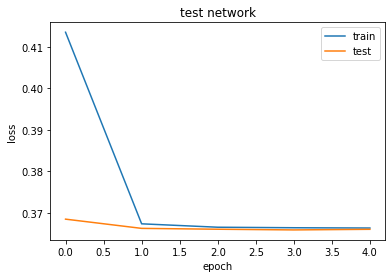

Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'mt', 'ptll', 'dphill', 'dphillm', 'SIG', 'PROB'],
      dtype='object')
nsig  125680
nbkg  124320


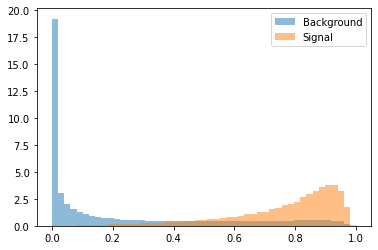

Logistic regression  auc  0.9028771301686394


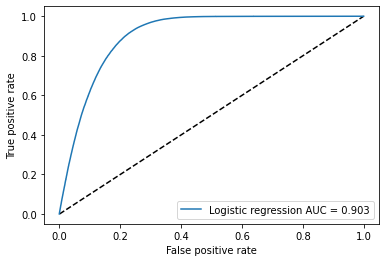

Logistic Regression:
 max significance is   5.329118661249793  nbg  3384.261287035262  nsig  315.2526235652418  cut  0.6812278
 background efficiency:  0.13825611325611326  signal efficiency:  0.7471196690006364


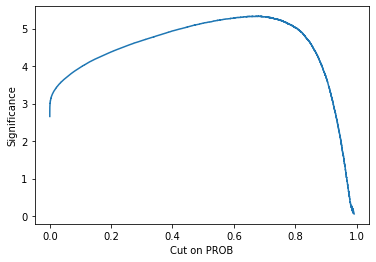

PROB<0.68117684 PROB>0.68117684


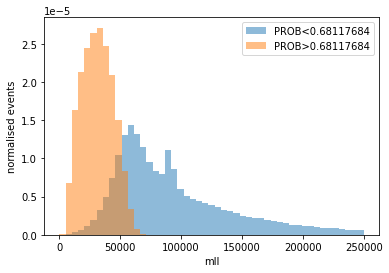

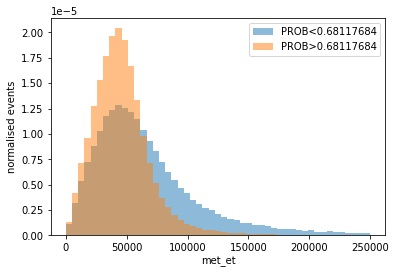

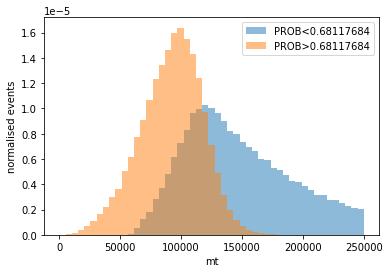

layer weights [[-1.0686367 ]
 [-0.4334792 ]
 [ 0.01686529]
 [ 0.00354896]
 [-0.01439123]
 [-0.00295858]
 [-0.19933143]
 [-2.8238766 ]
 [-1.7573187 ]
 [ 1.2144824 ]
 [ 0.360415  ]
 [ 0.4198463 ]]
layer biases [-1.3604649]


In [50]:
plothis(history, 'test network')
plt.show()

df_test_acc_r=X_test.copy()
df_test_acc_r['SIG']=y_test
df_test_acc_r['PROB']=Ypredr

print(df_test_acc_r.columns)
# split according to the label
df_test_acc_r_bkg = df_test_acc_r.query('SIG==0')
df_test_acc_r_sig = df_test_acc_r.query('SIG==1')
print('nsig ',df_test_acc_r_sig.shape[0])
print('nbkg ',df_test_acc_r_bkg.shape[0])
bins = np.linspace(0, 1,50)
plt.hist(df_test_acc_r_bkg.PROB, bins, alpha=0.5, density=True, label='Background')
plt.hist(df_test_acc_r_sig.PROB, bins, alpha=0.5, density=True, label='Signal')
plt.legend(loc='best')
plt.show()

plot_roc_single(y_test, Ypredr, 'Logistic regression')
plt.show()

thr, signi, imax=plot_signi_base(y_test, Ypredr, statMC['signal'], statMC['background'], 0.001, 'Logistic Regression')
plt.show()
thrmax=thr[imax]
sel1='PROB<'+str(thrmax)
sel2='PROB>'+str(thrmax)
print(sel1,sel2)
plot_varsel(df_test_acc_r, sel1, sel2, 'mll', 0.,250000, 50)
plot_varsel(df_test_acc_r, sel1, sel2, 'met_et', 0., 250000 , 50)
plot_varsel(df_test_acc_r, sel1, sel2, 'mt', 0., 250000 , 50)

layer_weights = model.layers[0].get_weights()[0]
layer_biases  = model.layers[0].get_weights()[1]
print('layer weights',layer_weights)
print('layer biases',layer_biases)

# Decision tree classifier

Documentation for the possible options is in <br />

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

test_tree = pd.DataFrame(X_test)
test_tree.columns=col_fin


clf = DecisionTreeClassifier(max_leaf_nodes=6, criterion='gini', splitter='best', random_state=0)
clf.fit(X_train, y_train)

Ypred_tree=clf.predict_proba(test_tree)

(250000, 2)
Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'mt', 'ptll', 'dphill', 'dphillm', 'SIG', 'PROB'],
      dtype='object')
nsig  125680
nbkg  124320


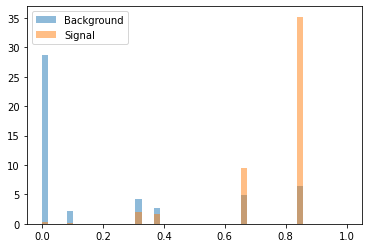

Decision Tree  auc  0.88816698306643


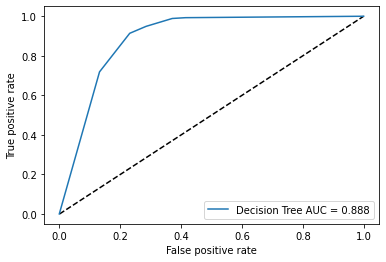

effsig  0.7186187141947804 effbg  0.13219916344916344
totsig 421.9573338056145 totbg 24478.20358414148
nsig= 303.22643666444844 nbg= 3235.9980365618176
significance 0.8 5.241547879235802


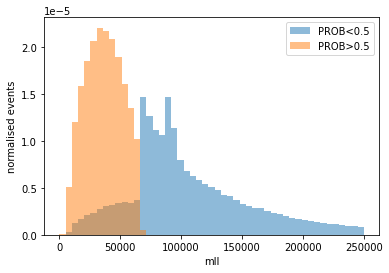

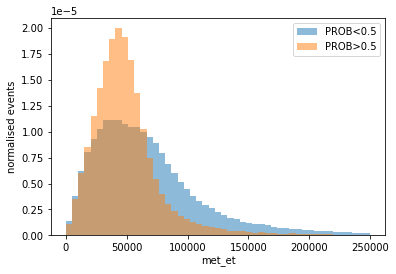

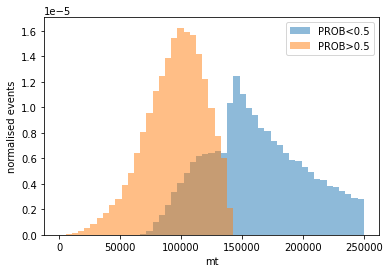

In [52]:
print(Ypred_tree.shape)
df_test_acc_t=X_test.copy()
df_test_acc_t['SIG']=y_test
df_test_acc_t['PROB']=Ypred_tree[:,1]

print(df_test_acc_t.columns)
# split according to the label
df_test_acc_t_bkg = df_test_acc_t.query('SIG==0')
df_test_acc_t_sig = df_test_acc_t.query('SIG==1')
print('nsig ',df_test_acc_t_sig.shape[0])
print('nbkg ',df_test_acc_t_bkg.shape[0])
bins = np.linspace(0, 1,50)
plt.hist(df_test_acc_t_bkg.PROB, bins, alpha=0.5, density=True, label='Background')
plt.hist(df_test_acc_t_sig.PROB, bins, alpha=0.5, density=True, label='Signal')
plt.legend(loc='best')

plt.show()

plot_roc_single(y_test, Ypred_tree[:,1], 'Decision Tree')
plt.show()

effsig= df_test_acc_t_sig.query('PROB>0.8').shape[0]/df_test_acc_t_sig.shape[0]
effbkg= df_test_acc_t_bkg.query('PROB>0.8').shape[0]/df_test_acc_t_bkg.shape[0]
print('effsig ',effsig,'effbg ',effbkg)
print('totsig',statMC['signal'],'totbg',statMC['background'])
print('significance 0.8',calc_sing_signi(effsig,effbkg,statMC['signal'],statMC['background'],0.001))
#plot_signi_base(y_test, Ypred_tree[:,1], statMC['signal'], statMC['background'], 0.01, 'Decision Tree')
#plt.show()



plot_varsel(df_test_acc_t, 'PROB<0.5', 'PROB>0.5', 'mll', 0.,250000, 50)
plot_varsel(df_test_acc_t, 'PROB<0.5', 'PROB>0.5', 'met_et', 0., 250000 , 50)
plot_varsel(df_test_acc_t, 'PROB<0.5', 'PROB>0.5', 'mt', 0., 250000 , 50)

In [55]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
dot_data = tree.export_graphviz(clf, out_file=None,
                     class_names=["bad","good"],
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("simple",view=True)

'simple.pdf'

# Esercizi

* Try to run Logistic Regression with non-renormalised variables and extract best significance
* Try to change optimiser for logistic regression 
* Try to remove the variables with lowest weights, and compare performance

* Add one layer to the LR model and compare performance -> this is the shallow learning
  * Vary parameters of added layer

* Modify parameteres in decision tree
  * In particular, increase number of leaves, and verify on graphical representation of the tree what id did 
* Rerun decision tree only with variables actually used by tree
